The purpose of this code is to create a venn diagram to highlight the overlap in affected genes for three cell lines with African genomes.

In [1]:
#Parameters/Arguments
working_dir = "/home/jupyter/notebooks/Ancestry"
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET')
out_directory = "avana14" #the output directory name

In [18]:
#Set up the environment

#load packages
library(dplyr)
library(tidyverse)
library(stringr)
library(plyr)
library(ggplot2)
library(ggVennDiagram)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

In [3]:
#Load in the depmap avana subset data matrix
paste(working_dir, "/raw_data/depmap/", out_directory, sep = "") %>% setwd()
avana.subset <- read.table("depmap_avana_collapsed_guide_snp_matrix.txt", header = T, sep = "\t")

colnames(avana.subset) <- gsub("\\.", "-", colnames(avana.subset)) #R replaced the '-' with '.' on loading, so fix that
avana.subset[1:10, 1:10] #display a bit of the data frame

,gene,sgrna,chr,pos,ACH.002214,ACH.001020,ACH.000317,ACH.000382,ACH.000172,ACH.000527
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,OR4F17,TCTCCATTCGGTGAGCCAGT,chr1,69534,0,0,0,0,0,0
2,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939354,0,0,0,0,0,0
3,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939355,0,0,0,0,0,0
4,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939356,0,0,0,0,0,0
5,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939358,0,0,0,0,0,0
6,NOC2L,CCATCTCTCAACCATGGCGA,chr1,956930,0,0,0,0,0,0
7,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961286,0,0,0,0,0,0
8,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961297,0,0,0,0,0,0
9,KLHL17,GCGTGGCCCACAACTCCAAG,chr1,961388,0,0,0,0,0,0


[1] 79727  1760

,gene,sgrna,chr,pos,ACH-002214,ACH-001020,ACH-000317,ACH-000382,ACH-000172,ACH-000527
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,OR4F17,TCTCCATTCGGTGAGCCAGT,chr1,69534,0,0,0,0,0,0
2,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939354,0,0,0,0,0,0
3,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939355,0,0,0,0,0,0
4,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939356,0,0,0,0,0,0
5,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939358,0,0,0,0,0,0
6,NOC2L,CCATCTCTCAACCATGGCGA,chr1,956930,0,0,0,0,0,0
7,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961286,0,0,0,0,0,0
8,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961297,0,0,0,0,0,0
9,KLHL17,GCGTGGCCCACAACTCCAAG,chr1,961388,0,0,0,0,0,0


In [4]:
#Filter the dataset to remove certain "genes" like "POTENTIALLY_ACTIVE_23"
start.genes <- nrow(avana.subset)
avana.subset <- avana.subset[!grepl("_",avana.subset$gene),]
end.genes <- nrow(avana.subset)
print(paste("There were ", start.genes-end.genes, " genes that were cut from the data frame."))

[1] "There were  164  genes that were cut from the data frame."


In [26]:
#Subset the matrix to only include our cell lines of interest
lines.of.interest <- c("ACH-000748", "ACH-000654", "ACH-000763")
columns.to.keep <- c("gene", lines.of.interest)

subset.matrix <- avana.subset[ ,columns.to.keep]
head(subset.matrix)


ERROR: Error in `[.data.frame`(avana.subset, , columns.to.keep): undefined columns selected


In [8]:
#Collapse the matrix by gene name

#Just like we did above, collapse the dataset by gene names
show_msg(glue::glue("Collapsing by gene name"))
avana.subset.collapsed <- aggregate(. ~ gene, data = subset.matrix, FUN = sum)


#Convert all of the numbers that are greater than 1 to be 1. A number greater than 1 means that there are multiple SNPs in that guide. But we just want a binary indicator of whether or not there is a SNP in that guide
show_msg(glue::glue("Recoding gene-level matrix"))
gene <- avana.subset.collapsed$gene #Take a vector of the sgrna labels
avana.subset.collapsed[avana.subset.collapsed > 1] <- 1 #Convert all of the numbers larger than 1 to be equal to 1
avana.subset.collapsed$gene <- gene #Assign the sgrna names back to the matrix
colnames(avana.subset.collapsed)[1] <- "gene"

head(avana.subset.collapsed)

Collapsing by gene name
Recoding gene-level matrix


,gene,ACH-000748,ACH-000654,ACH-000763
,<chr>,<dbl>,<dbl>,<dbl>
1,A1BG,1,1,1
2,A1CF,0,0,0
3,A2M,0,0,0
4,A2ML1,0,0,0
5,A3GALT2,0,0,0
6,A4GALT,0,0,0


In [11]:
#Filter the dataset to remove unaffected genes
row.sum.vector <- rowSums(avana.subset.collapsed[,2:4])
aasc <- avana.subset.collapsed[row.sum.vector >= 1, ]
head(aasc)

,gene,ACH-000748,ACH-000654,ACH-000763
,<chr>,<dbl>,<dbl>,<dbl>
1,A1BG,1,1,1
11,AADACL2,1,1,1
17,AAMDC,0,0,1
24,AARSD1,1,1,1
32,ABCA1,0,0,1
48,ABCB5,1,0,0


In [31]:
###Create the list for the venn diagram

ACH000748 <- avana.subset.collapsed[,2]
ACH000654 <- avana.subset.collapsed[,3]
ACH000763 <- avana.subset.collapsed[,4]


ACH000748 <- avana.subset.collapsed$gene[ACH000748 == 1]
ACH000654 <- avana.subset.collapsed$gene[ACH000654 == 1]
ACH000763 <- avana.subset.collapsed$gene[ACH000763 == 1]


venn.list <- NULL
venn.list[[1]] <- ACH000748
venn.list[[2]] <- ACH000654
venn.list[[3]] <- ACH000763



List of 3
 $ : chr [1:943] "A1BG" "AADACL2" "AARSD1" "ABCB5" ...
 $ : chr [1:1119] "A1BG" "AADACL2" "AARSD1" "ABHD1" ...
 $ : chr [1:1017] "A1BG" "AADACL2" "AAMDC" "AARSD1" ...


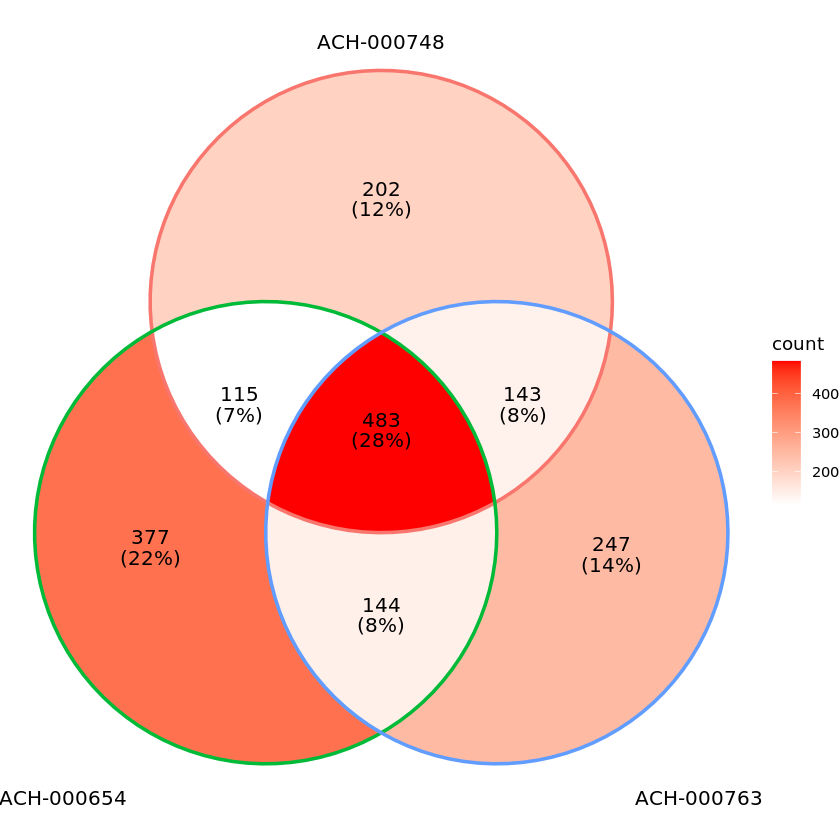

In [50]:
#plot the ggplot

ggVennDiagram(venn.list, label_alpha = 0, category.names = c("ACH-000748","ACH-000654","ACH-000763")
  ) +

ggplot2::scale_fill_gradient(low="white",high = "red") 

In [51]:
#export the plot

paste(working_dir, "/figures", sep ="") %>% setwd()
ggsave("three_individual_genomes.tiff") #save the plot

system(glue::glue("
cd {working_dir}/figures
gsutil cp three_individual_genomes.tiff gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Saving 6.67 x 6.67 in image



In [53]:
write.table(aasc, "aasc_to_look_at.txt", sep = "\t")

system(glue::glue("
cd {working_dir}/figures
gsutil cp aasc_to_look_at.txt gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))